In [1]:
print("apple")

apple


## Google Driveのマウント

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
! pwd

/content


In [12]:
! ls drive/MyDrive/'Colab Notebooks'/experiment_001

config.json	   special_tokens_map.json  training_args.bin
model.safetensors  tokenizer_config.json    vocab.txt


## 保存したモデルディレクトリの存在確認

In [18]:
import os

dir_notebooks = "Colab Notebooks"
# チェックしたいフォルダのパス
model_path = "/content/drive/MyDrive/{}/experiment_001".format(dir_notebooks)

# フォルダが存在するか確認
if os.path.exists(model_path):
  print(f"フォルダ '{model_path}' は存在します。")
else:
  print(f"フォルダ '{model_path}' は存在しません。")

フォルダ '/content/drive/MyDrive/Colab Notebooks/experiment_001' は存在します。


## 環境構築

In [19]:
# huggingface transformer のインストール
# - transformers : 主たるモジュール（モデルやトークナイザのダウンロード)
# - datasets : HuggingFaceで、データセットを扱うためのモジュール
# https://huggingface.co/docs/transformers/installation
! pip install transformers
! pip install datasets==v2.11.0

# 東北大学の日本語用BERT使用に必要なパッケージをインストール
! pip install fugashi ipadic

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 88.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.0/698.0 kB 44.1 MB/s eta 0:00:00
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556704 sha256=6d48301fffc3f1e9639fac9ddc1cefe87457e24efde90f131973975cc79179e1
  Stored in directory: /root/.cache/pip/wheels/44/56/37/f543963822b85260c9f948df8fac8c20169c80dc71b24dc407
Successfully built ipadic


## Matplotlib で日本語フォントを使用できるようにする

In [40]:
!ls /root/.cache/matplotlib

fontlist-v390.json


インストールとキャッシュ削除

In [43]:
# [前準備] Matplotlib で日本語フォントを使用できるようにする
# cf. https://blog.3qe.us/entry/2018/08/16/121457
!apt-get -y install fonts-ipafont-gothic
#!rm /root/.cache/matplotlib/fontlist-v310.json
#!rm /root/.cache/matplotlib/fontlist-v300.json
!rm /root/.cache/matplotlib/fontlist-v390.json
!pip install japanize-matplotlib

# NOTE ここで、ランタイムを再起動

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
rm: cannot remove '/root/.cache/matplotlib/fontlist-v390.json': No such file or directory
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 77.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=03e3d213bdaf3aec4856e8a72556445cc8fbc863f02403d4de3e13a2e5cfac2d
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize-matplotlib


Text(0.5, 1.0, '日本語を表示できるかテスト')

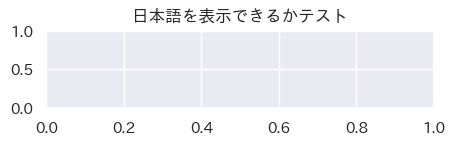

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

# sns.set_theme(font='IPAexGothic')
# 動作確認
plt.figure(figsize=(5,1))
plt.title('日本語を表示できるかテスト')


In [ ]:
### Tokenizerで入力データに変換

In [22]:
! pip install unidic_lite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for unidic_lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658818 sha256=c3190caf01cb24e38d10dfaa0aac15a3d24655b5761df31b49ceff6eb4d8f229
  Stored in directory: /root/.cache/pip/wheels/b7/fd/e9/ea4459b868e6d2902e8d80e82dbacb6203e05b3b3a58c64966
Successfully built unidic_lite


In [23]:
# 一般的にpandasはpdと名前を付けてimportされる
import pandas as pd
import numpy as np

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

## 読み込んだモデルで推論する

In [45]:
# https://www.delftstack.com/ja/howto/numpy/numpy-softmax/
def np_softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

def analyze_emotion(text, show_fig=False, ret_prob=False):
    # 推論モードを有効か
    model.eval()

    # 入力データ変換 + 推論
    tokens = tokenizer(text, truncation=True, return_tensors="pt")
    tokens.to(model.device)
    preds = model(**tokens)
    prob = np_softmax(preds.logits.cpu().detach().numpy()[0])
    out_dict = {n: p for n, p in zip(emotion_names_jp, prob)}

    # 棒グラフを描画
    if show_fig:
        plt.figure(figsize=(8, 3))
        df = pd.DataFrame(out_dict.items(), columns=['name', 'prob'])
        sns.barplot(x='name', y='prob', data=df)
        plt.title('入力文 : ' + text, fontsize=15)

    if ret_prob:
        return out_dict

In [46]:
# Plutchikの8つの基本感情
emotion_names = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']
emotion_names_jp = ['喜び', '悲しみ', '期待', '驚き', '怒り', '恐れ', '嫌悪', '信頼']  # 日本語版
num_labels = len(emotion_names)

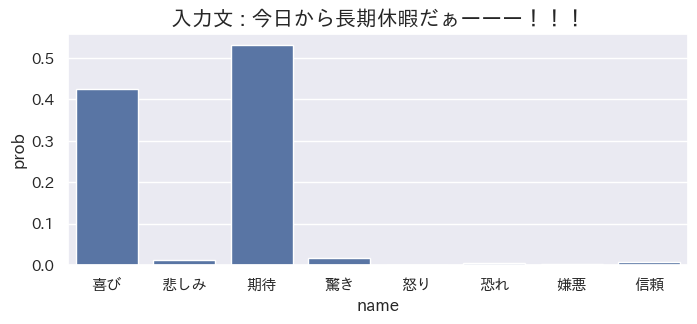

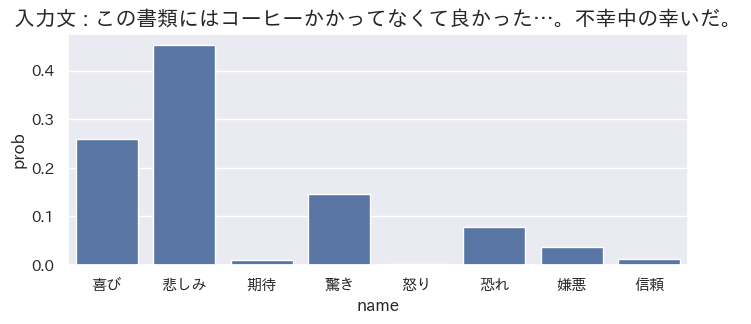

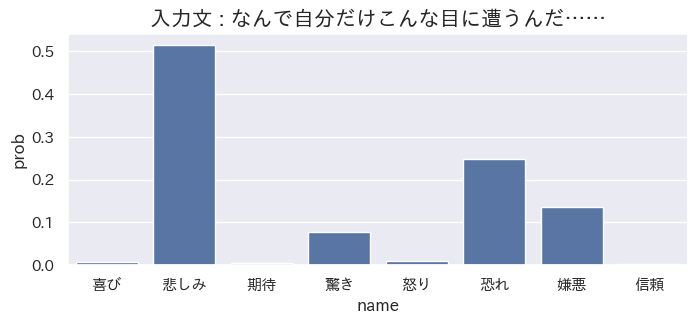

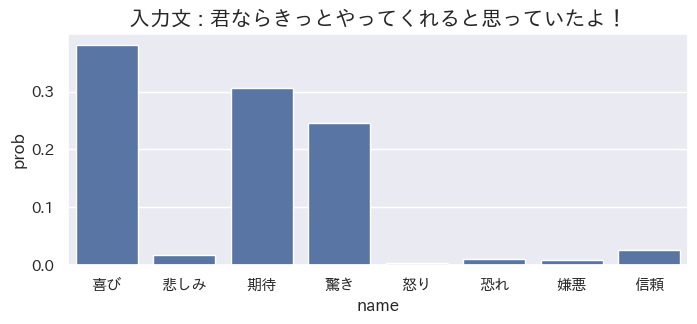

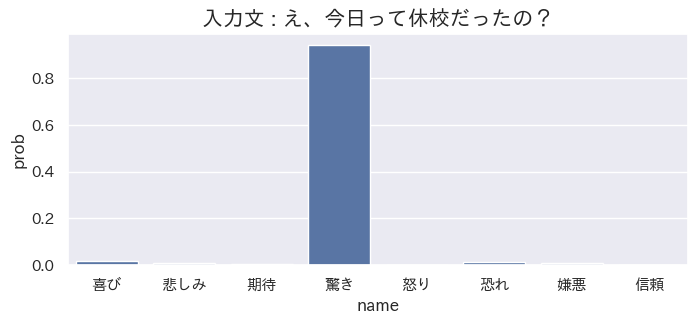

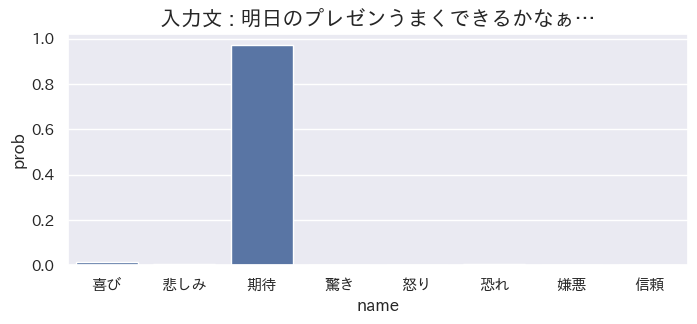

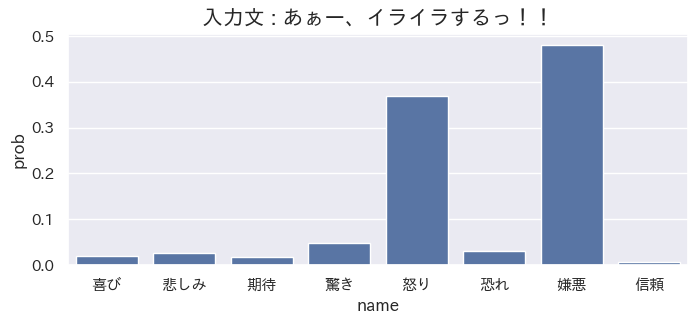

In [47]:
# モデルを読み込む
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# tokenizerを読み込む
tokenizer = AutoTokenizer.from_pretrained(model_path)


# 動作確認
analyze_emotion('今日から長期休暇だぁーーー！！！', show_fig=True)


analyze_emotion('この書類にはコーヒーかかってなくて良かった…。不幸中の幸いだ。', show_fig=True)



analyze_emotion('なんで自分だけこんな目に遭うんだ……', show_fig=True)


analyze_emotion('君ならきっとやってくれると思っていたよ！', show_fig=True)


analyze_emotion('え、今日って休校だったの？', show_fig=True)


analyze_emotion('明日のプレゼンうまくできるかなぁ…', show_fig=True)



analyze_emotion('あぁー、イライラするっ！！', show_fig=True)
